In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from utils import make_confusion_matrix, plot_metrics, get_features, atomic_benchmark_estimator

import tensorflow as tf

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline


In [4]:
df = pd.read_csv("./data/Notebook 2 Data/data.csv")
df.head()

,AGERNG,GENDER,EDU,PROF,MARSTS,RESDPL,LIVWTH,ENVSAT,POSSAT,FINSTR,DEBT,PHYEX,SMOKE,DRINK,ILLNESS,PREMED,EATDIS,AVGSLP,INSOM,TSSN,WRKPRE,ANXI,DEPRI,ABUSED,CHEAT,THREAT,SUICIDE,INFER,CONFLICT,LOST,DEPRESSED
0,26-30,Female,Post Graduate,Unemployed,Unmarried,Town,With Family,Yes,Yes,No,No,Sometimes,No,Yes,No,No,No,More than 8 hours,No,2-4 hours a day,No Pressure,Yes,No,No,No,No,No,No,Yes,No,0
1,26-30,Male,Post Graduate,Service holder (Private),Unmarried,City,With Family,Yes,No,Yes,No,Never,No,No,No,No,No,6 hours,Yes,5-7 hours a day,Moderate,Yes,Yes,Yes,No,No,No,Yes,No,No,1
2,21-25,Male,HSC,Student,Unmarried,City,With Family,Yes,Yes,No,No,Never,No,No,No,No,No,8 hours,No,8-10 hours a day,Mild,Yes,Yes,No,No,No,No,No,No,No,0
3,16-20,Male,HSC,Student,Unmarried,City,With Family,No,Yes,No,No,Sometimes,No,No,No,No,No,7 hours,No,2-4 hours a day,Severe,Yes,Yes,No,Yes,No,No,No,No,No,1
4,21-25,Male,Graduate,Student,Unmarried,Town,With Family,No,Yes,Yes,No,Never,No,No,No,Yes,No,7 hours,Yes,5-7 hours a day,Mild,Yes,Yes,No,No,No,No,Yes,Yes,No,1


In [5]:
df["DEPRESSED"].value_counts()

1    397
0    207
Name: DEPRESSED, dtype: int64

In [6]:
categorical_cols, numerical_cols, _ = get_features(df)

In [7]:
len(categorical_cols), len(numerical_cols)

(30, 1)

In [8]:
for cat in categorical_cols:
    en = LabelEncoder()
    en.fit(df[cat])
    print(cat, list(en.classes_))
    df[cat] = en.transform(df[cat])

AGERNG ['16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61+']
GENDER ['Female', 'Male']
EDU ['Graduate', 'HSC', 'Post Graduate', 'SSC']
PROF ['Businessman', 'Other', 'Service holder (Government)', 'Service holder (Private)', 'Student', 'Unemployed']
MARSTS ['Divorced', 'Married', 'Unmarried']
RESDPL ['City', 'Town', 'Village']
LIVWTH ['With Family', 'Without Family']
ENVSAT ['No', 'Yes']
POSSAT ['No', 'Yes']
FINSTR ['No', 'Yes']
DEBT ['No', 'Yes']
PHYEX ['Never', 'Regularly', 'Sometimes']
SMOKE ['No', 'Yes']
DRINK ['No', 'Yes']
ILLNESS ['No', 'Yes']
PREMED ['No', 'Yes']
EATDIS ['No', 'Yes']
AVGSLP ['5 hours', '6 hours', '7 hours', '8 hours', 'Below 5 hours', 'More than 8 hours']
INSOM ['No', 'Yes']
TSSN ['2-4 hours a day', '5-7 hours a day', '8-10 hours a day', 'Less than 2 hours', 'More than 10 hours a day']
WRKPRE ['Mild', 'Moderate', 'No Pressure', 'Severe']
ANXI ['No', 'Yes']
DEPRI ['No', 'Yes']
ABUSED ['No', 'Yes']
CHEAT ['No', 'Yes']
THREAT ['No'

In [9]:
df.head()

,AGERNG,GENDER,EDU,PROF,MARSTS,RESDPL,LIVWTH,ENVSAT,POSSAT,FINSTR,DEBT,PHYEX,SMOKE,DRINK,ILLNESS,PREMED,EATDIS,AVGSLP,INSOM,TSSN,WRKPRE,ANXI,DEPRI,ABUSED,CHEAT,THREAT,SUICIDE,INFER,CONFLICT,LOST,DEPRESSED
0,2,0,2,5,2,1,0,1,1,0,0,2,0,1,0,0,0,5,0,0,2,1,0,0,0,0,0,0,1,0,0
1,2,1,2,3,2,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0,0,1
2,1,1,1,4,2,0,0,1,1,0,0,0,0,0,0,0,0,3,0,2,0,1,1,0,0,0,0,0,0,0,0
3,0,1,1,4,2,0,0,0,1,0,0,2,0,0,0,0,0,2,0,0,3,1,1,0,1,0,0,0,0,0,1
4,1,1,0,4,2,1,0,0,1,1,0,0,0,0,0,1,0,2,1,1,0,1,1,0,0,0,0,1,1,0,1


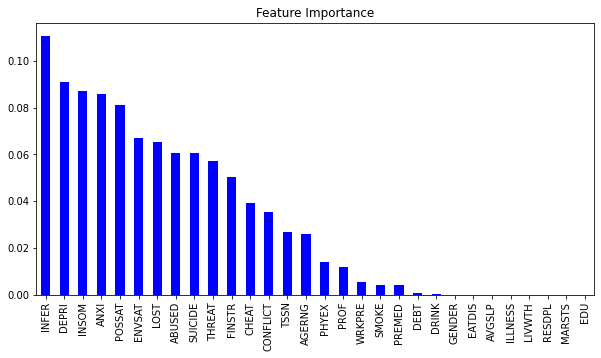

In [10]:
features = df.drop("DEPRESSED", axis=1)

mutual_info = mutual_info_classif(features, df["DEPRESSED"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns
plt.figure(figsize=(10, 5))
mutual_info.sort_values(ascending=False).plot.bar(color="b")
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

In [11]:
target = df['DEPRESSED']
X_train, X_valid, y_train, y_valid = train_test_split(
    df, target, test_size=0.2, stratify=target, random_state=99)

X_train = X_train.drop(['DEPRESSED'], axis=1)
X_valid = X_valid.drop(['DEPRESSED'], axis=1)

In [12]:
process = tf.keras.layers.Normalization()
process.adapt(X_train)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (X_valid, y_valid)).batch(128).prefetch(tf.data.AUTOTUNE)

In [14]:
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['0', '1']
METRICS = ["acc"]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc', patience=10, restore_best_weights=True, mode="max")


In [15]:
tf.random.set_seed(222)

input = tf.keras.layers.Input(shape=(30, ))
x = process(input)
# x = tf.keras.layers.Dense(28, activation="relu")(x)
x = tf.keras.layers.Dense(24, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

nn_1 = tf.keras.Model(input, output)

nn_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=METRICS
)
# nn_1.summary()
history_1 = nn_1.fit(
    train_dataset,
    epochs=500,
    validation_data=valid_dataset,
    # callbacks=[early_stopping],
    verbose=2
)

Epoch 1/500
4/4 - 1s - loss: 0.6690 - acc: 0.6542 - val_loss: 0.6496 - val_acc: 0.6612 - 1s/epoch - 318ms/step
Epoch 2/500
4/4 - 0s - loss: 0.6558 - acc: 0.6563 - val_loss: 0.6377 - val_acc: 0.6612 - 39ms/epoch - 10ms/step
Epoch 3/500
4/4 - 0s - loss: 0.6419 - acc: 0.6563 - val_loss: 0.6243 - val_acc: 0.6612 - 42ms/epoch - 10ms/step
Epoch 4/500
4/4 - 0s - loss: 0.6269 - acc: 0.6563 - val_loss: 0.6099 - val_acc: 0.6612 - 41ms/epoch - 10ms/step
Epoch 5/500
4/4 - 0s - loss: 0.6107 - acc: 0.6563 - val_loss: 0.5947 - val_acc: 0.6612 - 47ms/epoch - 12ms/step
Epoch 6/500
4/4 - 0s - loss: 0.5936 - acc: 0.6563 - val_loss: 0.5777 - val_acc: 0.6612 - 46ms/epoch - 11ms/step
Epoch 7/500
4/4 - 0s - loss: 0.5764 - acc: 0.6563 - val_loss: 0.5607 - val_acc: 0.6612 - 44ms/epoch - 11ms/step
Epoch 8/500
4/4 - 0s - loss: 0.5600 - acc: 0.6563 - val_loss: 0.5447 - val_acc: 0.6612 - 33ms/epoch - 8ms/step
Epoch 9/500
4/4 - 0s - loss: 0.5440 - acc: 0.6563 - val_loss: 0.5297 - val_acc: 0.6612 - 32ms/epoch - 8ms/

In [16]:
y_pred = nn_1.predict(X_valid).squeeze()
y_pred = tf.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.numpy()
y_pred


array([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

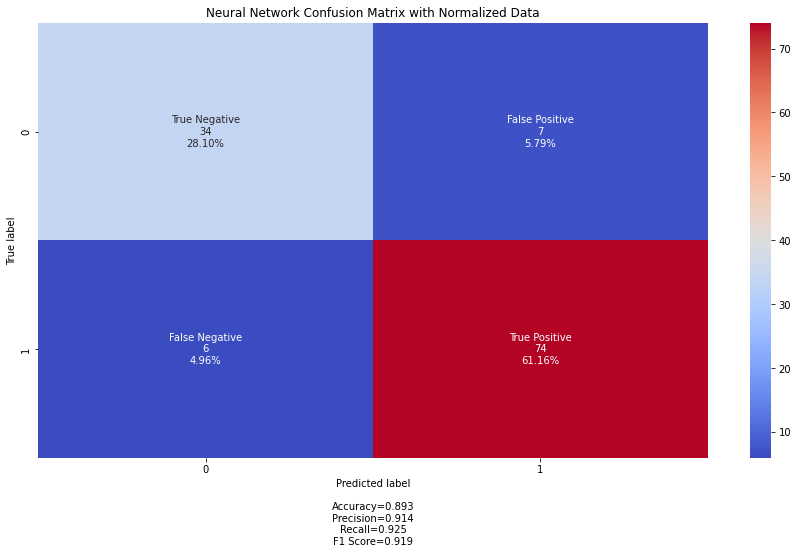

In [17]:
y_pred = nn_1.predict(X_valid).squeeze()
y_pred = tf.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.numpy()

cf = confusion_matrix(y_valid, y_pred)
accuracy = np.trace(cf) / float(np.sum(cf))
runtimes = atomic_benchmark_estimator(nn_1, pd.DataFrame(X_valid))

make_confusion_matrix(
    cf,
    group_names=labels,
    categories=categories,
    cmap='coolwarm',
    figsize=(15, 8),
    title="Neural Network Confusion Matrix with Normalized Data"
)

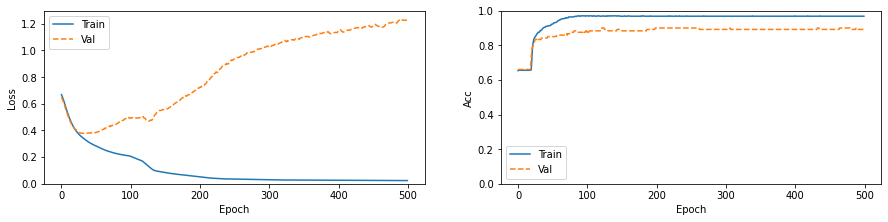

In [18]:
plt.figure(figsize=(15, 7))
plot_metrics(history_1)

In [21]:
nn_1.save("model.h5")

In [22]:
!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model model.h5 model/

Writing weight file model/model.json...


2022-06-10 00:38:03.222662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 00:38:03.743334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2038 MB memory:  -> device: 0, name: GeForce GTX 1650 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-06-10 00:38:04.640602: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-10 00:38:05.258320: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-06-10 00:38:05.258687: I tensorflow/core/grappler/cluste

: 

In [20]:
nn_1.predict([
    2, 1, 2, 3, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
    0, 0, 0, 1, 0, 0,
])


array([[1.]], dtype=float32)